# Proyecto ALPR
Por Brian A. Flores Lopez

In [1]:
pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

# Importación de las librerias y conexión con google drive para acceder al dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import easyocr

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Lectura y procesamiento de las imágenes y etiquetas xml

In [4]:
# Parámetros
IMAGE_RESIZE_X = 224
IMAGE_RESIZE_Y = 224

# Leer y procesar imágenes de los coches
car_folder_path = '/content/drive/MyDrive/rawData/images'
car_image_name_list = sorted([os.path.join(car_folder_path, car_image) for car_image in os.listdir(car_folder_path)], key=lambda x: int(x.split('/')[-1].split('.')[0][4:]))
resized_car_images_list = [cv2.resize(cv2.imread(full_path), (IMAGE_RESIZE_X, IMAGE_RESIZE_Y)) for full_path in car_image_name_list]
print('Read in {} resized car images'.format(len(resized_car_images_list)))

# Leer y procesar anotaciones de las matrículas
plate_folder_path = '/content/drive/MyDrive/rawData/annotations'
plate_name_list = sorted([os.path.join(plate_folder_path, plate_file) for plate_file in os.listdir(plate_folder_path)], key=lambda x: int(x.split('/')[-1].split('.')[0][4:]))
resized_plate_location_list = []
for full_path in plate_name_list:
    xml_file = open(full_path, 'r')
    bs = BeautifulSoup(xml_file, "xml")
    width, height = int(bs.find('width').text), int(bs.find('height').text)
    xMax, xMin = int(bs.find('xmax').text) * (IMAGE_RESIZE_X / width), int(bs.find('xmin').text) * (IMAGE_RESIZE_X / width)
    yMax, yMin = int(bs.find('ymax').text) * (IMAGE_RESIZE_Y / height), int(bs.find('ymin').text) * (IMAGE_RESIZE_Y / height)
    resized_plate_location_list.append([int(xMax), int(xMin), int(yMax), int(yMin)])
print('Read in {} resized plate info'.format(len(plate_name_list)))


Read in 433 resized car images
Read in 433 resized plate info


Visualización de las imágenes con las cajas delimitadoras

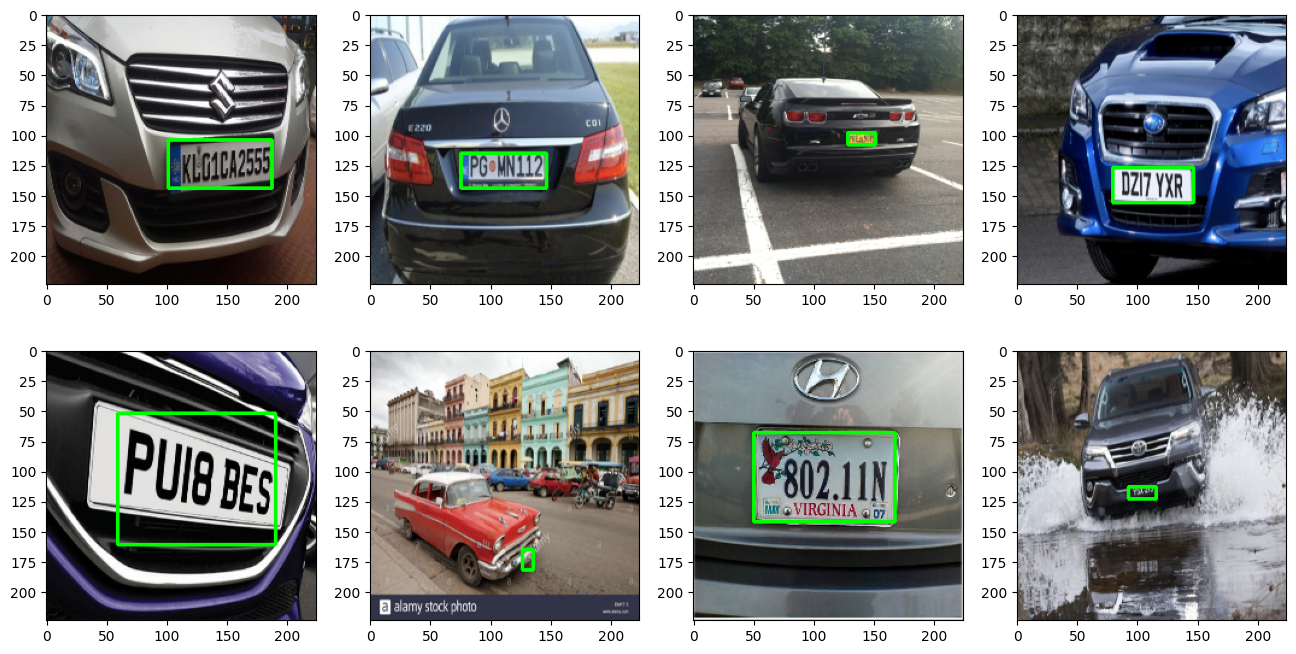

In [5]:
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    top_left = (resized_plate_location_list[i][1], resized_plate_location_list[i][3])
    bottom_right = (resized_plate_location_list[i][0], resized_plate_location_list[i][2])
    car_image_copy = resized_car_images_list[i].copy()
    cv2.rectangle(car_image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(car_image_copy, cv2.COLOR_BGR2RGB))


# Definición de parámetros, funciones auxiliares y definición de los modelos

In [3]:
#Parámetros
EPOCHS = 50
BATCH_SIZE = 32

def splitTrainTestSet(resized_car_images_list, resized_plate_location_list):
    resized_car_images_list_np = np.array(resized_car_images_list) / 255.0
    resized_plate_location_list_np = np.array(resized_plate_location_list) / 200.0
    X_train, X_test, y_train, y_test = train_test_split(resized_car_images_list_np, resized_plate_location_list_np, test_size=0.1, random_state=7)
    return X_train, X_test, y_train, y_test

def setupModel(modelType):
    cnn = Sequential()
    if modelType == 'VGG16':
        cnn.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_RESIZE_X, IMAGE_RESIZE_Y, 3)))
        cnn.add(Dropout(0.5))
        cnn.add(Flatten())
        cnn.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        cnn.add(Dropout(0.5))
        cnn.add(Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        cnn.add(Dense(64, activation="relu"))
        cnn.add(Dense(4, activation="sigmoid"))
    elif modelType == 'cnn':
        cnn.add(keras.layers.Conv2D(filters=16, kernel_size=5, input_shape=(IMAGE_RESIZE_X, IMAGE_RESIZE_Y, 3), padding='same'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
        cnn.add(Dropout(0.5))
        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
        cnn.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding='same'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
        cnn.add(Dropout(0.5))
        cnn.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same'))
        cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
        cnn.add(Flatten())
        cnn.add(Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        cnn.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        cnn.add(Dense(4, activation="sigmoid"))
    return cnn


# Configuración y compilación del modelo

In [6]:
modelType = 'VGG16' # Red neuronal usada
model = setupModel(modelType)
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])


58889256/58889256 [==============================] - 0s 0us/step


# Entrenamiento del modelo con aumento de datos

In [7]:
# Cargar y dividir datos
X_train, X_test, y_train, y_test = splitTrainTestSet(resized_car_images_list, resized_plate_location_list)

# Configuración del Aumento de Datos
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Entrenamiento del modelo con aumento de datos
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) / BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/50
12/12 [==============================] - 48s 3s/step - loss: 0.6214 - mean_absolute_error: 0.2314 - val_loss: 0.4590 - val_mean_absolute_error: 0.1966
Epoch 2/50
12/12 [==============================] - 7s 551ms/step - loss: 0.4136 - mean_absolute_error: 0.1599 - val_loss: 0.4064 - val_mean_absolute_error: 0.1619
Epoch 3/50
12/12 [==============================] - 11s 911ms/step - loss: 0.3779 - mean_absolute_error: 0.1505 - val_loss: 0.3596 - val_mean_absolute_error: 0.1484
Epoch 4/50
12/12 [==============================] - 7s 556ms/step - loss: 0.3516 - mean_absolute_error: 0.1513 - val_loss: 0.3430 - val_mean_absolute_error: 0.1538
Epoch 5/50
12/12 [==============================] - 8s 629ms/step - loss: 0.3293 - mean_absolute_error: 0.1492 - val_loss: 0.3235 - val_mean_absolute_error: 0.1536
Epoch 6/50
12/12 [==============================] - 9s 767ms/step - loss: 0.3079 - mean_absolute_error: 0.1462 - val_loss: 0.2993 - val_mean_absolute_error: 0.1458
Epoch 7/50
12/12 

Mean Absolute Error: 0.12


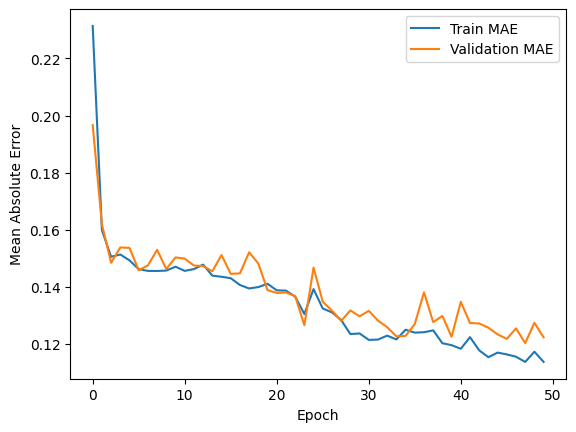

In [8]:
# Evaluación del modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Mean Absolute Error: %.2f" % scores[1])

# Visualización del proceso de entrenamiento
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


1/1 [==============================] - 0s 79ms/step


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


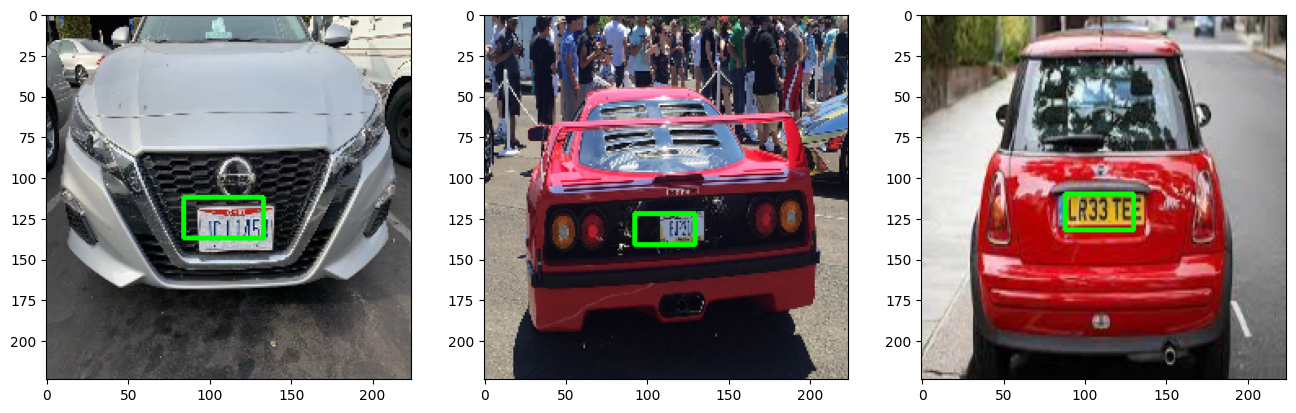

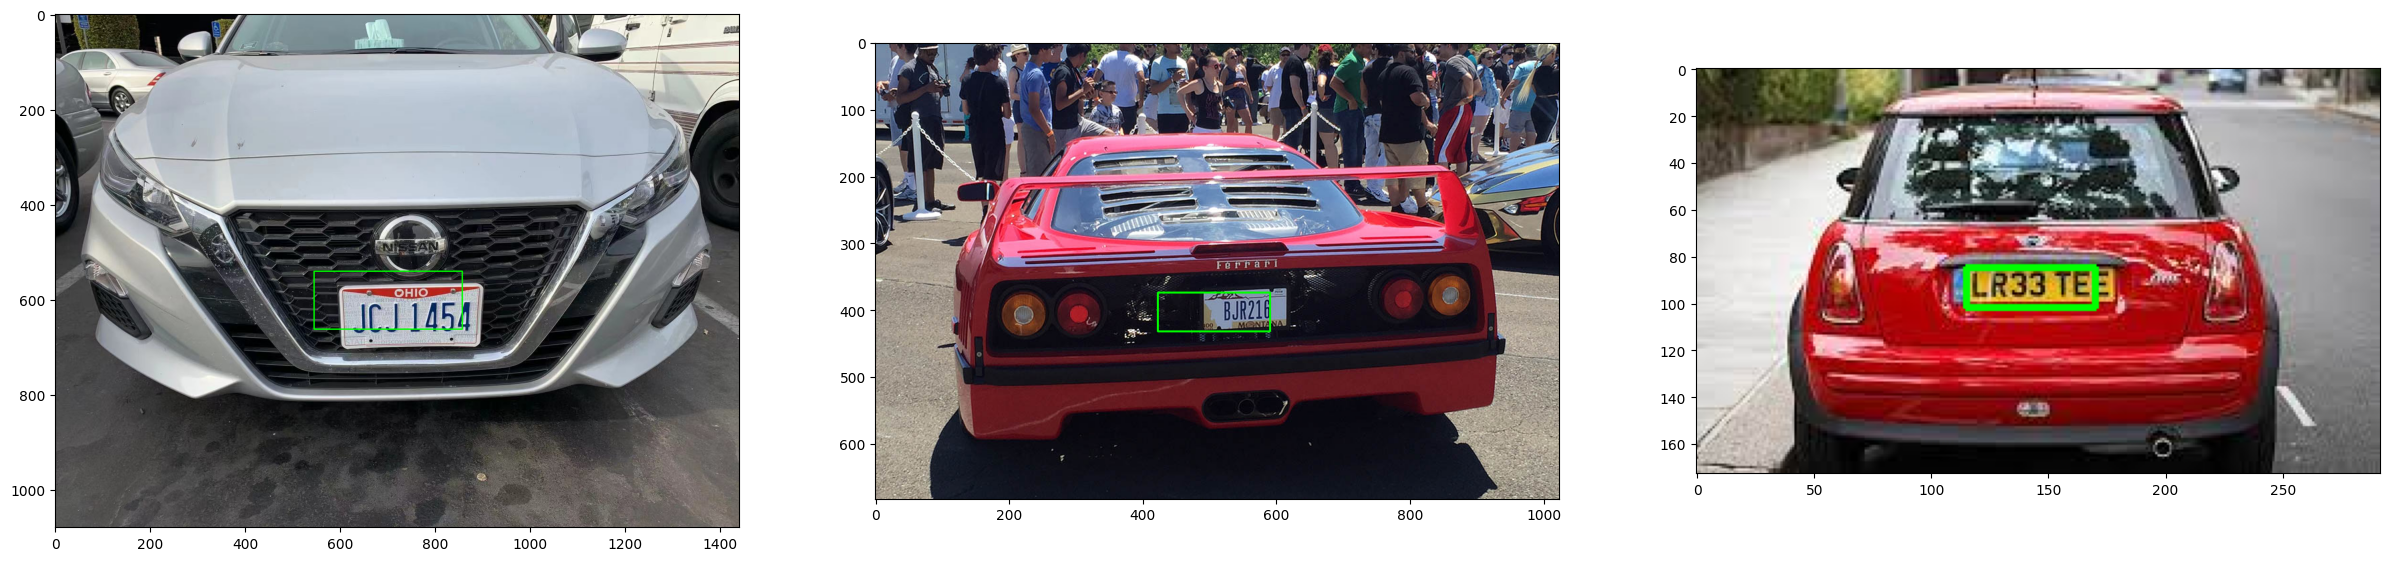

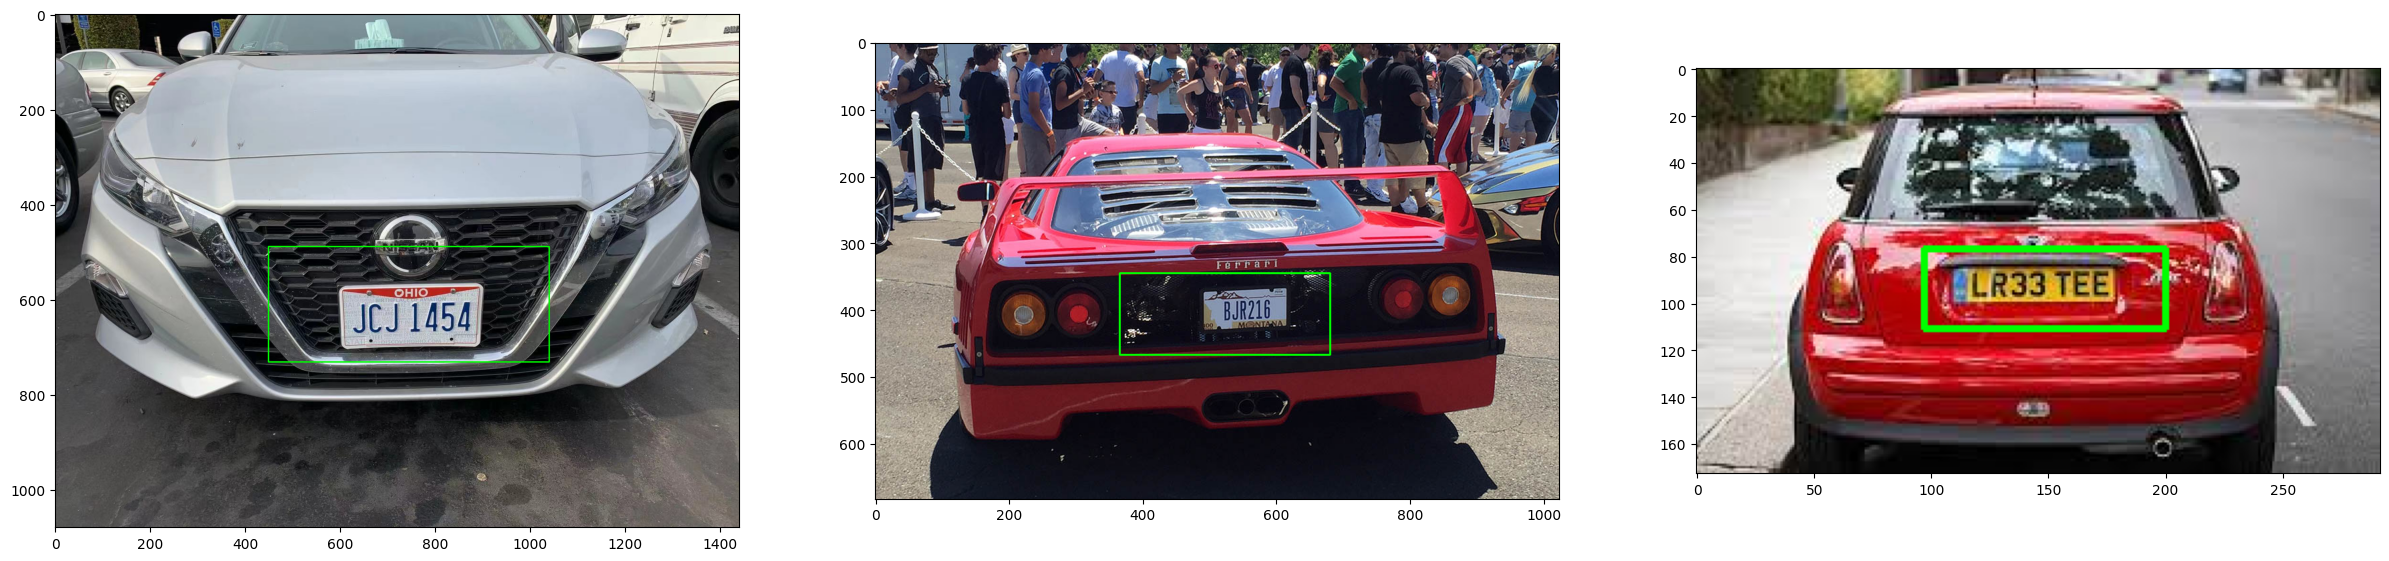

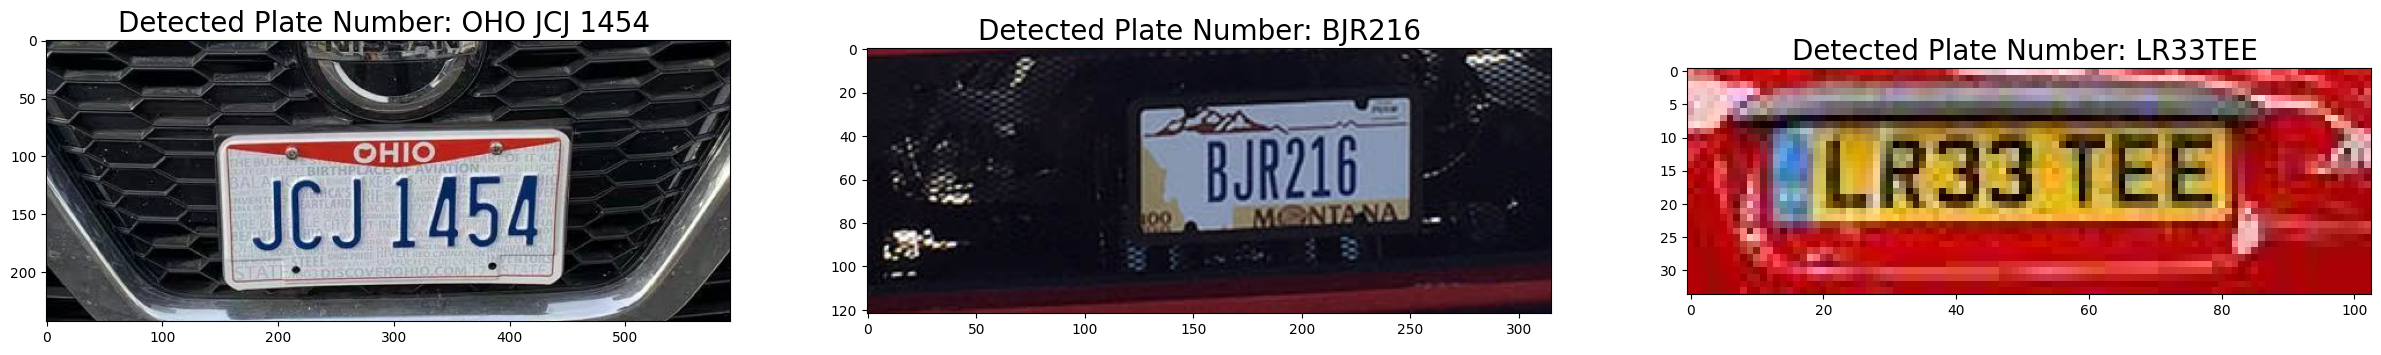

In [10]:
test_image_folder = '/content/drive/MyDrive/testImages/'
test_image_list = ['img1.jpg', 'img5.jpg', 'img7.jpg']
resized_test_image_list = list()
orginal_test_image_list = list()
test_image_orginal_size = list()
for test_image in test_image_list:
    full_path = os.path.join(test_image_folder, test_image)
    car_image = cv2.imread(full_path)
    orginal_test_image_list.append(car_image)
    test_image_orginal_size.append(car_image.shape)
    car_resize_image = cv2.resize(car_image, (IMAGE_RESIZE_X, IMAGE_RESIZE_Y))
    resized_test_image_list.append(np.array(car_resize_image))

resized_test_image_list = np.array(resized_test_image_list) / 255.0

# Predicción
plate_location = model.predict(resized_test_image_list)

# Visualización de los resultados
plt.figure(figsize=(16, 8))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    car_image_copy = (resized_test_image_list[i] * 255).astype('uint8')
    top_left = (int(plate_location[i][1] * 200), int(plate_location[i][3] * 200))
    bottom_right = (int(plate_location[i][0] * 200), int(plate_location[i][2] * 200))
    cv2.rectangle(car_image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(car_image_copy, cv2.COLOR_BGR2RGB))

plate_location_origianl_scale = []
for i in range(len(test_image_orginal_size)):
    plate_location_resized = plate_location[i] * 200
    test_image_size = test_image_orginal_size[i]
    height, width = test_image_size[0], test_image_size[1]
    original_xMax = plate_location_resized[0] * (width / IMAGE_RESIZE_X)
    original_xMin = plate_location_resized[1] * (width / IMAGE_RESIZE_X)
    original_yMax = plate_location_resized[2] * (height / IMAGE_RESIZE_Y)
    original_yMin = plate_location_resized[3] * (height / IMAGE_RESIZE_Y)
    plate_location_origianl_scale.append([int(original_xMax), int(original_xMin), int(original_yMax), int(original_yMin)])

plt.figure(figsize=(30, 10))
for i in range(len(orginal_test_image_list)):
    plt.subplot(1, len(orginal_test_image_list), i + 1)
    image_copy = orginal_test_image_list[i].copy()
    top_left = (plate_location_origianl_scale[i][1], plate_location_origianl_scale[i][3])
    bottom_right = (plate_location_origianl_scale[i][0], plate_location_origianl_scale[i][2])
    cv2.rectangle(image_copy, top_left, bottom_right, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

# Reconocer texto de las matrículas usando EasyOCR
plate_image_list = []
plt.figure(figsize=(30, 10))
for i in range(len(orginal_test_image_list)):
    plt.subplot(1, len(orginal_test_image_list), i + 1)
    image_copy = orginal_test_image_list[i].copy()
    top_left = (plate_location_origianl_scale[i][1], plate_location_origianl_scale[i][3])
    bottom_right = (plate_location_origianl_scale[i][0], plate_location_origianl_scale[i][2])

    # Ajustar la caja delimitadora para asegurar que toda la matrícula esté visible
    box_image_ratio_height = (bottom_right[1] - top_left[1]) / image_copy.shape[0]
    box_image_ratio_width = (bottom_right[0] - top_left[0]) / image_copy.shape[1]

    height_coef = 1 + ((1 / (np.log(box_image_ratio_height))**2) / 2)
    width_coef = 1 + ((1 / (np.log(box_image_ratio_width))**2) / 2)

    top_left_adjusted = (int(top_left[0] / width_coef), int(top_left[1] / height_coef))
    bottom_right_adjusted = (int(bottom_right[0] * width_coef), int(bottom_right[1] * height_coef))

    cv2.rectangle(image_copy, top_left_adjusted, bottom_right_adjusted, color=(0, 255, 0), thickness=2)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))

    plate_image = orginal_test_image_list[i][top_left_adjusted[1]:bottom_right_adjusted[1], top_left_adjusted[0]:bottom_right_adjusted[0], :]
    plate_image_list.append(plate_image)

# Configurar el lector EasyOCR
reader = easyocr.Reader(['en'])

# Mostrar las matrículas y el texto detectado
plt.figure(figsize=(30, 10))
for i, plate in enumerate(plate_image_list):
    plt.subplot(1, len(plate_image_list), i + 1)
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))

    bounds = reader.readtext(plate)
    title_text = ''
    for text in bounds:
        title_text += text[1] + ' '
    plt.title('Detected Plate Number: ' + title_text, fontdict={'fontsize': 20})
